In [16]:
import numpy as np
import rcca
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import normalize

import torch
import umap

# from mcfa import mcfa_model
# from mcfa import gsea
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from statsmodels.stats import multitest

In [187]:
ephys = pd.read_pickle("D:/Data For Publication/CCA/ephys_with_labels.p")
ephys = ephys.drop_duplicates('exp_name')
bio = pd.read_pickle("D:/Data For Publication/CCA/biophys_with_labels.pkl")
bio = bio.drop_duplicates('exp_name')
sta = pd.read_pickle("D:/Data For Publication/CCA/sta_with_labels.pkl")
sta = sta.drop_duplicates('exp_name')
sta_fleur = pd.read_pickle('D:/CurrentClamp/all_stas_fleur.pkl')
sta_fleur = sta_fleur.drop_duplicates('exp_name')
sta_fleur = sta_fleur[sta_fleur.exp_name.isin(sta.exp_name)]

In [188]:
# sta.labels_wave
sta_fleur['labels_wave']  = sta.labels_wave

In [201]:
ephys_exc  = ephys[~ephys.labels_wave.isin([0,4,5])] 
ephys_inh  = ephys[ephys.labels_wave.isin([0,4,5])] 


bio_exc =  bio[bio.labels_wave==1]
bio_inh =  bio[bio.labels_wave==0]

bio_exc = bio_exc[bio_exc.r_squared_V>0.7]
bio_inh = bio_inh[bio_inh.r_squared_V>0.7]

sta_exc = sta_fleur[sta_fleur.labels_wave==1]
sta_inh = sta_fleur[sta_fleur.labels_wave==0]

sta_exc = sta_fleur[sta_fleur.labels_wave==1]
sta_inh = sta_fleur[sta_fleur.labels_wave==0]



exc_exps = list(set(sta_exc.exp_name) & set(bio_exc.exp_name) & set(ephys_exc.exp_name))
inh_exps = list(set(sta_inh.exp_name) & set(bio_inh.exp_name) & set(ephys_inh.exp_name))


ephys_exc = ephys_exc[ephys_exc.exp_name.isin(exc_exps)]
ephys_inh = ephys_inh[ephys_inh.exp_name.isin(inh_exps)]


bio_exc = bio_exc[bio_exc.exp_name.isin(exc_exps)]
bio_inh = bio_inh[bio_inh.exp_name.isin(inh_exps)]

sta_exc = sta_exc[sta_exc.exp_name.isin(exc_exps)]
sta_inh = sta_inh[sta_inh.exp_name.isin(inh_exps)]

In [190]:
cols_ephys = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',]
cols_bio = bio_inh.columns[:9]


In [191]:
bio_inh.columns[:9]

Index(['tau_m (ms)', 'R (MOhm)', 'C (nF)', 'gl (nS)', 'El (mV)', 'Tref (ms)',
       'Vr (mV)', 'Vt* (mV)', 'DV (mV)'],
      dtype='object')

In [192]:
cols_bio = ['tau_m (ms)', 'C (nF)', 'gl (nS)', 'El (mV)', 'Vr (mV)', 'Vt* (mV)', 'DV (mV)',]

<Axes: >

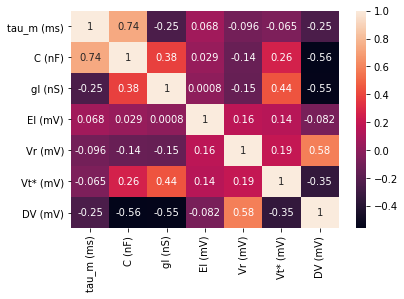

In [22]:
sns.heatmap(bio_inh[cols_bio].corr(),annot=True)

In [205]:
sta_exc['sta'].to_numpy().shape[0]

114

In [213]:
np.vstack(sta_exc['sta'].to_numpy()).shape 

(114, 111)

In [214]:
df_sta_exc = pd.DataFrame(columns=np.arange(np.vstack(sta_exc['sta'].to_numpy()).shape[1]))
df_sta_exc[df_sta_exc.columns] = normalize(np.vstack(sta_exc['sta'].to_numpy()))
bio_exc[cols_bio] = bio_exc[cols_bio].to_numpy(dtype=np.float32)

df_eta_exc = pd.DataFrame(columns=np.arange(10759))

df_eta_exc[df_eta_exc.columns]  = normalize(np.float32(np.vstack(bio_exc['eta'].to_numpy())))

ephys_exc[cols_ephys] = ephys_exc[cols_ephys].to_numpy(dtype=np.float32)

In [219]:
df_sta_inh = pd.DataFrame(columns=np.arange(np.vstack(sta_exc['sta'].to_numpy()).shape[1]))
df_sta_inh[df_sta_inh.columns] =normalize(np.vstack(sta_inh['sta'].to_numpy()))
bio_inh[cols_bio] = bio_inh[cols_bio].to_numpy(dtype=np.float32)

df_eta_inh = pd.DataFrame(columns=np.arange(10759))

df_eta_inh[df_eta_inh.columns]  =  normalize(np.float32(np.vstack(bio_inh['eta'].to_numpy())))

ephys_inh[cols_ephys] = ephys_inh[cols_ephys].to_numpy(dtype=np.float32)

In [224]:
ephys[['time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi']] = ephys[['time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi']]/1000 

In [228]:
from multicor_fa import mcfa_model

Y_inh = {
    "ephys": ephys_inh[cols_ephys].reset_index(drop='index'), 
    "bio": bio_inh[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_inh,
    'eta':df_eta_inh
    }

Y_exc = {
    "ephys": ephys_exc[cols_ephys].reset_index(drop='index'), 
    "bio": bio_exc[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_exc,
    'eta':df_eta_exc
    }



mcfa_res_inh = mcfa_model.fit(Y_inh,) 
mcfa_res_exc = mcfa_model.fit(Y_exc,) #k=[1,1,1,1]   

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.6417970657348633.
Fitting the model.
iter: 0 Likelihood: 2760.0029296875
Iter: 1 Likelihood: 2741.377685546875 Percent change: 0.006794118241649533 Time (s): 0.002009868621826172
Iter: 2 Likelihood: 2739.841064453125 Percent change: 0.000560843150241896 Time (s): 0.006009578704833984
Iter: 3 Likelihood: 2739.3095703125 Percent change: 0.0001940248544323405 Time (s): 0.009009361267089844
Iter: 4 Likelihood: 2738.994140625 Percent change: 0.00011516260032159958 Time (s): 0.014112234115600586
Iter: 5 Likelihood: 2738.75830078125 Percent change: 8.61119594535688e-05 Time (s): 0.018584251403808594
Iter: 6 Likelihood: 2738.562744140625 Percent change: 7.140849375951277e-05 Time (s): 0.02157425880432129
Iter: 7 Likelihood: 2738.391845703125 Percent change: 6.240832106192573e-05 Time (s): 0.024970054626464844
Iter: 8 Likelihood: 2738.238525390625 Per

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 4 components above rho inclusion threshold 1.6220505237579346.
Fitting the model.
iter: 0 Likelihood: 6721.73583984375
Iter: 1 Likelihood: 6667.78369140625 Percent change: 0.00809146651038426 Time (s): 0.008525371551513672
Iter: 2 Likelihood: 6659.7705078125 Percent change: 0.0012032221807568033 Time (s): 0.01620316505432129
Iter: 3 Likelihood: 6656.85693359375 Percent change: 0.0004376801616460588 Time (s): 0.025222301483154297
Iter: 4 Likelihood: 6655.36328125 Percent change: 0.00022442837161992823 Time (s): 0.03222823143005371
Iter: 5 Likelihood: 6654.3994140625 Percent change: 0.0001448466086155115 Time (s): 0.042308807373046875
Iter: 6 Likelihood: 6653.6767578125 Percent change: 0.00010861006272231122 Time (s): 0.05000638961791992
Iter: 7 Likelihood: 6653.08740234375 Percent change: 8.85837556473979e-05 Time (s): 0.058046579360961914
Iter: 8 Likelihood: 6652.578125 Percent change: 

In [ ]:
Z_cv, X_cv, nrmse_tr, nrmse_te = mcfa_model.cv(Y_inh, mcfa_res_inh, threads=0, folds = 'loo') 

In [229]:
mcfa_res_df_inh = pd.concat([mcfa_res_inh.Z] + list(mcfa_res_inh.X.values()), axis=1)
mcfa_res_df_exc = pd.concat([mcfa_res_exc.Z] + list(mcfa_res_exc.X.values()), axis=1)

In [230]:

var_exp_private_exc = {mode: ve_X.sum() for mode, ve_X in mcfa_res_exc.var_exp_X.items()}
var_exp_shared_exc = mcfa_res_exc.var_exp_Z.sum()
var_exp_totals_exc = pd.DataFrame({'Shared': var_exp_shared_exc, 'Specific': var_exp_private_exc})
var_exp_totals_exc['Total'] = var_exp_totals_exc['Shared'] + var_exp_totals_exc['Specific']
var_exp_normed_exc = (mcfa_res_exc.var_exp_Z/var_exp_totals_exc['Total']).T
var_exp_totals_exc['Residual'] = 1 - var_exp_totals_exc['Total']
var_exp_totals_exc = var_exp_totals_exc.drop('Total', axis=1)


var_exp_private_inh = {mode: ve_X.sum() for mode, ve_X in mcfa_res_inh.var_exp_X.items()}
var_exp_shared_inh = mcfa_res_inh.var_exp_Z.sum()
var_exp_totals_inh = pd.DataFrame({'Shared': var_exp_shared_inh, 'Specific': var_exp_private_inh})
var_exp_totals_inh['Total'] = var_exp_totals_inh['Shared'] + var_exp_totals_inh['Specific']
var_exp_normed_inh = (mcfa_res_inh.var_exp_Z/var_exp_totals_inh['Total']).T
var_exp_totals_inh['Residual'] = 1 - var_exp_totals_inh['Total']
var_exp_totals_inh = var_exp_totals_inh.drop('Total', axis=1)

In [82]:
# mcfa_res_exc.var_exp_Z


In [231]:

var_exp_totals_exc['dataset'] = var_exp_totals_exc.index
var_exp_totals_exc = var_exp_totals_exc.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

var_exp_totals_inh['dataset'] = var_exp_totals_inh.index
var_exp_totals_inh = var_exp_totals_inh.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

In [232]:
var_exp_totals_exc

,dataset,Space,Variance explained
0,ephys,Shared,0.586517
1,bio,Shared,0.360651
2,sta,Shared,0.421352
3,eta,Shared,0.201713
4,ephys,Specific,0.000000
5,bio,Specific,0.000000
6,sta,Specific,0.034339
7,eta,Specific,0.617231
8,ephys,Residual,0.413483
9,bio,Residual,0.639349


In [233]:
var_exp_totals_inh

,dataset,Space,Variance explained
0,ephys,Shared,0.177295
1,bio,Shared,0.147620
2,sta,Shared,0.323223
3,eta,Shared,0.267513
4,ephys,Specific,0.144184
5,bio,Specific,0.000000
6,sta,Specific,0.081933
7,eta,Specific,0.565613
8,ephys,Residual,0.678521
9,bio,Residual,0.852380


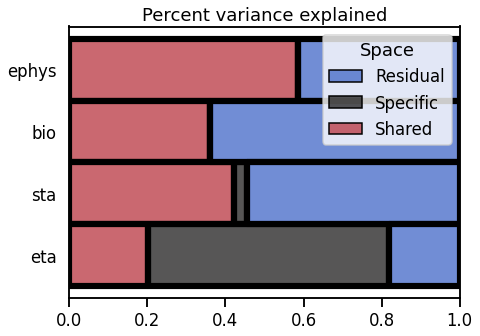

<ipython-input-234-a77f612caece>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','sta','eta'])


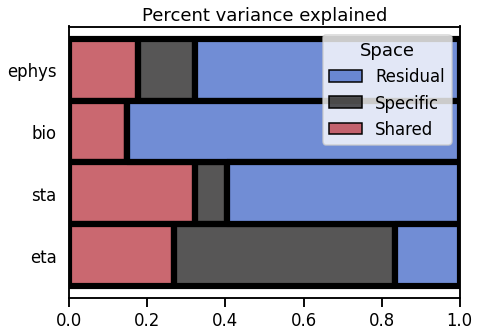

In [234]:
# sns.set_context('talk')
savepath = 'D:/Data For Publication/figures/part2/'
fig,ax = plt.subplots(figsize=(7, 5))
var_exp_totals_exc['Space'] = pd.Categorical(var_exp_totals_exc['Space'], ['Residual', 'Specific', 'Shared'])
sns.histplot(var_exp_totals_exc, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire',ax =ax)
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set_yticklabels=['ephys','bio','sta','eta']
# plt.savefig(savepath+'alpha_exc.svg',dpi=200)
plt.show() 

# fig,ax = plt.subplots(figsize=(7, 5))

sns.set_context('talk')
plt.figure(figsize=(7, 5))
var_exp_totals_inh['Space'] = pd.Categorical(var_exp_totals_inh['Space'], ['Residual', 'Specific', 'Shared'])
ax = sns.histplot(var_exp_totals_inh, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire')
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set(yticklabels=['ephys', 'bio','sta','eta'])
# plt.savefig(savepath+'beta_inh.svg',dpi=100)

plt.show() 

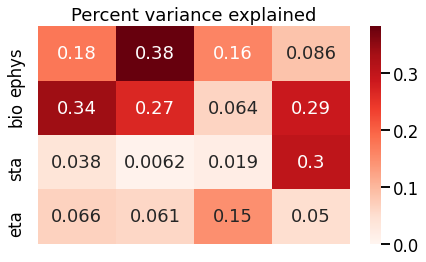

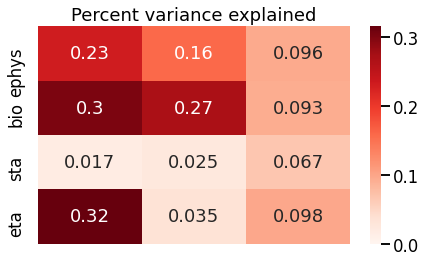

In [171]:

sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_exc, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'exc_var_per_factor.pdf',dpi=200)
plt.show()


sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_inh, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'inh_var_per_factor.pdf',dpi=200)

plt.show()

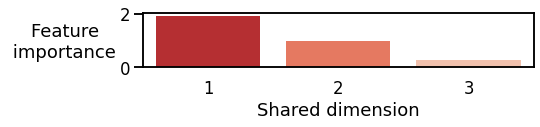

In [159]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_inh.rho.index, y=mcfa_res_inh.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 4))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_inh.pdf',dpi=200)
plt.show()

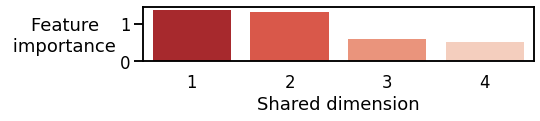

In [160]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_exc.rho.index, y=mcfa_res_exc.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 5))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_exc.pdf',dpi=200)
plt.show()

In [148]:

embedding_Z_inh = umap.UMAP(random_state=42).fit_transform(mcfa_res_inh.Z)

embedding_Z_exc = umap.UMAP(random_state=42).fit_transform(mcfa_res_exc.Z)

# embedding_exp = umap.UMAP().fit_transform(X_ephys)
# embedding_methyl = umap.UMAP().fit_transform(X_methyl)
# embedding_protein = umap.UMAP().fit_transform(X_protein)
# embedding_metab = umap.UMAP().fit_transform(X_metab)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [152]:
mcfa_res_exc.X

{'ephys':      X1_ephys  X2_ephys
 0    0.228764 -0.431200
 1    1.188288  0.342113
 2    0.037165 -0.605961
 3    0.136702 -0.344971
 4   -0.917578 -0.535981
 ..        ...       ...
 178  1.113502  0.170804
 179  0.711264 -0.016447
 180  1.698454 -0.775880
 181 -0.060849  0.071975
 182  1.168993  0.109748
 
 [183 rows x 2 columns],
 'bio':        X1_bio
 0    0.403215
 1    0.603291
 2   -0.168017
 3    0.114877
 4   -0.170264
 ..        ...
 178  0.012212
 179 -0.079009
 180 -0.886526
 181 -0.238684
 182  0.311723
 
 [183 rows x 1 columns],
 'sta':        X1_sta    X2_sta
 0   -0.297408  0.900699
 1   -0.092242 -0.298635
 2   -0.640509  1.219874
 3   -0.213495 -0.507959
 4   -0.728088  0.386915
 ..        ...       ...
 178 -0.450199  0.171559
 179 -0.365992 -0.184298
 180  2.474248 -0.036245
 181 -0.527038  0.637054
 182  0.030001 -0.845005
 
 [183 rows x 2 columns],
 'eta':        X1_eta    X2_eta
 0    0.641335 -0.174401
 1   -0.216842  0.021187
 2   -0.728028 -0.196450
 3    0.7

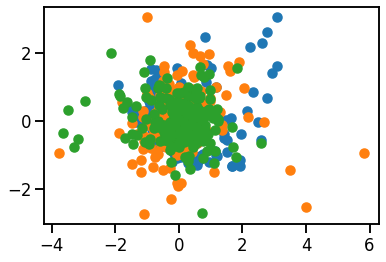

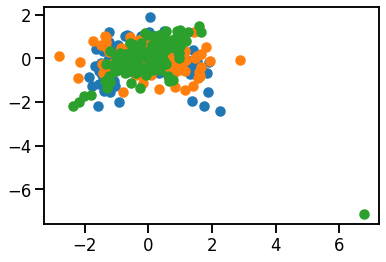

In [161]:
# plt.scatter(np.arange(len(mcfa_res_inh.X['ephys'])),mcfa_res_inh.X['ephys'])
plt.scatter(mcfa_res_exc.X['sta']['X1_sta'], mcfa_res_exc.X['sta']['X2_sta'])

plt.scatter(mcfa_res_exc.X['eta']['X1_eta'], mcfa_res_exc.X['eta']['X2_eta'])


plt.scatter(mcfa_res_exc.X['ephys']['X1_ephys'], mcfa_res_exc.X['ephys']['X2_ephys'])

# plt.scatter(np.arange(len(mcfa_res_inh.X['bio'])),mcfa_res_inh.X['bio'])
# plt.scatter(np.arange(len(mcfa_res_inh.X['eta'])),mcfa_res_inh.X['eta'])
plt.show()
plt.scatter(mcfa_res_inh.X['sta']['X1_sta'], mcfa_res_inh.X['sta']['X2_sta'])

plt.scatter(mcfa_res_inh.X['eta']['X1_eta'], mcfa_res_inh.X['eta']['X2_eta'])


plt.scatter(mcfa_res_inh.X['ephys']['X1_ephys'], mcfa_res_inh.X['ephys']['X2_ephys'])


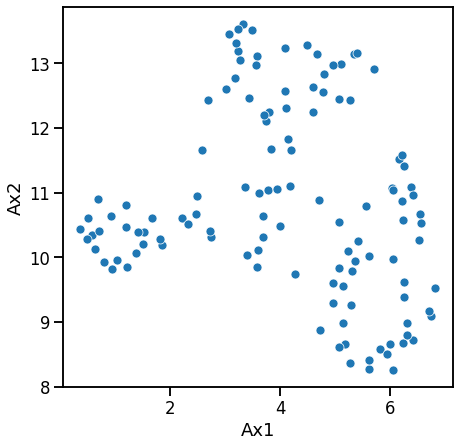

In [149]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z_inh, columns=['Ax1', 'Ax2']), x='Ax1', y='Ax2', palette='colorblind')
plt.show()

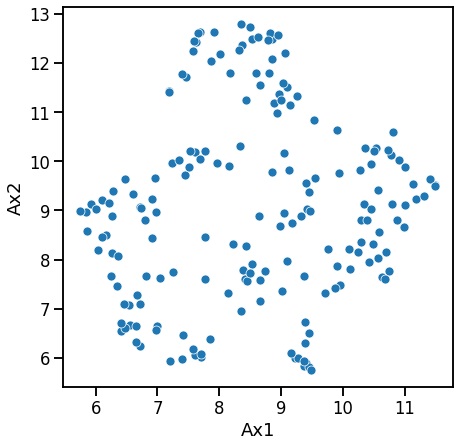

In [150]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z_exc, columns=['Ax1', 'Ax2']), x='Ax1', y='Ax2', palette='colorblind')
plt.show()